## Analysis of 20bn something something dataset for preprocessing

(analysis by Edit)

https://20bn.com/datasets/something-something  
https://arxiv.org/abs/1804.09235

**Size:**  
220,847 videos  
Training 168,913  
Validation 24,777  
Test 27,157  

**Labels:**  
50 coarse-grained action groups  
174 action categories e.g."Putting [something] onto [something]"  
318,572 annotations and 30,408 unique objects e.g. “Putting a blue cup onto a table"  
  
**Resolution:**  
height 240px  
width variable (further analysis below)

**FPS:**  
12  

**Number of frames per video:**  
variable (further analysis below). Videos are very short, some have less than 48 frames.


**Comments:**  
In most videos, the actions are performed from the first-person point of view. Few videos we could see half a human, and in a few no human at all (just camera movement, or even no movement)


In [1]:
import glob, os 
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imresize
import pandas as pd

### 1) Extract the raw videos in .webm format to image frames :  

**Done. See extract_20bn.py script**

Other info:  
1) How to check framerate 
https://askubuntu.com/questions/110264/how-to-find-frames-per-second-of-any-video-file  
2) ffmpeg guide  https://en.wikibooks.org/wiki/FFMPEG_An_Intermediate_Guide/image_sequence  
3) http://scikit-image.org/docs/dev/user_guide/video.html

In [3]:
data_dir = "/data/videos/something-something-v2/preprocessed" 

In [3]:
vid_list = [vid for vid in glob.glob(data_dir+"/test/*")]+ [vid for vid in glob.glob(data_dir+"/val/*")]

In [ ]:
df = pd.DataFrame({"path":vid_list})
print("Doing analysis only on the test+val splits (because the train split is too large to work with). \nTotal videos = {}".format(len(df)))

In [15]:
for i, vid_path in enumerate(df['path']):
    # read the first frame of the video
    im = imread(vid_path + "/image-001.png")
    df.loc[i,'height'] = int(im.shape[0])
    df.loc[i,'width'] = int(im.shape[1])
    df.loc[i,'aspect_ratio'] = im.shape[0]/im.shape[1]
    df.loc[i, 'num_of_frames'] = int(len(os.listdir(vid_path)))
    arr = im.flatten()
    df.loc[i, 'first_frame_mean'] = np.mean(arr)
    df.loc[i, 'first_frame_std'] = np.std(arr)
    df.loc[i, 'first_frame_min'] = np.min(arr)
    df.loc[i, 'first_frame_max'] = np.max(arr)
    
df.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,path,height,width,shape,aspect_ratio,num_of_frames,first_frame_mean,first_frame_std,first_frame_range,first_frame_min,first_frame_max
0,/data/videos/something-something-v2/preprocess...,240.0,320.0,NaN,0.750000,37.0,130.355838,71.238771,NaN,0.0,255.0
1,/data/videos/something-something-v2/preprocess...,240.0,427.0,NaN,0.562061,61.0,78.672271,37.705300,NaN,0.0,255.0
2,/data/videos/something-something-v2/preprocess...,240.0,427.0,NaN,0.562061,45.0,98.768940,40.095602,NaN,0.0,255.0
3,/data/videos/something-something-v2/preprocess...,240.0,320.0,NaN,0.750000,24.0,123.142995,52.340972,NaN,0.0,255.0
4,/data/videos/something-something-v2/preprocess...,240.0,427.0,NaN,0.562061,44.0,96.639117,56.877654,NaN,0.0,190.0


### 2) Frame resize, center-crop size and data augumentations :  
 1) The width or frames vary widely in then range (135, 528) as seen in the histogram below.  
 2) The frame resize shall be performed such that frame resize conserves the aspect ratio of the original frames.  
 3) Then random-crop the extra-width of the frames (same region cropped for all frames of one video) with a binomial distribution having max probability at the center of the video.  
 4) Random horizontal flipping of all frames of an video with 50% probability. However if enabled, some  labels must also be modified appropriately.  
(3), (4) from [Karpathy et. al. (2014)](https://arxiv.org/pdf/1503.08909.pdf).   

**Follwing from the below analysis, 3 experiments will be performed :**  
(also taking into consideration the constraint set by PredNet that width,height must be should-be-divisible-by-2^(layers-1) i.e. divisible by 16)   

#### Experiment 1 - (128,160) :   
Conserving aspect ratio at the cost of loss of useful sections of the video. almost all videos can be random-cropped

| aspect-ratio group| width range | # of videos | portion of dataset | resize by conserving aspect-ratio | random-crop to | side-effects |   
|------|------|------|------|------|------|------|
|0| < 300    | 971 | 1.86% | remove these videos | - | -|
|1| 300 - 419    | 15311| 29.58% | (128,160) to (128,223) | (128,160)| cropped out [0,63] width |
|2| >420  | 35652 | 68% | (128,224) to (128,281) | (128,160)| cropped out ~[64,100] width. Might lose useful regions |

#### Experiment 2 - (128,224) :    
Aspect ratio not conserved for 30% of the videos. useful secions retained. 70% videos can be random-cropped although won't have a lot of effect.

| aspect-ratio group| width range | # of videos | portion of dataset | resize | random-crop to | side-effects |   
|------|------|------|------|------|------|------|
|0| < 300    | 971 | 1.86% | remove these videos | - | -|
|1| 300 - 419    | 15311| 29.58% | (128,224) | - | no crop. Aspect size distorted |
|2| >420  | 35652 | 68% | (128,224) to (128,281) | (128,224)| cropped out ~[0,30] width. Random crop won't have a large effect|

#### Experiment 3 - (128,160) with no random crop

#### Experiment 4 - Horizontal flip + best setup among above 3 experiments :    
following labels must be modified dynamically if horizontal flip is enabled -    
     *'Pulling [something] from right to left'*   
     *'Pushing [something] from left to right'*  
     *'Pushing [something] from right to left'*   
     *'Pulling [something] from left to right'*   
     *'Turning the camera right while filming [something]'*  
     *'Turning the camera left while filming [something]'*  
     
| split | number of videos with these labels |
|-------|-------|
|train  |   9769|
|test   |    ?|
|val    |    1079|

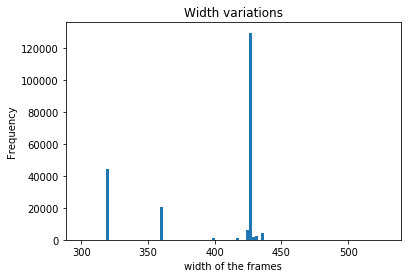

Width	 num_of_videos
300.0        59
305.0         1
313.0       113
319.0         1
320.0     44318
321.0         1
324.0         1
327.0         1
330.0         1
335.0         1
339.0         1
352.0        29
358.0         8
359.0         1
360.0     20328
361.0       365
362.0        72
379.0         1
384.0        42
387.0         1
400.0      1083
408.0         1
410.0         2
417.0       935
420.0         8
422.0         3
424.0      6331
425.0         7
426.0       791
427.0    128835
428.0      1648
429.0        21
430.0         3
432.0      2317
433.0         1
436.0      4328
437.0         2
439.0        29
447.0         1
463.0         4
480.0         2
483.0         3
494.0         8
502.0         1
528.0         1
Name: width, dtype: int64


In [14]:
y = df['width']
ax = y.plot.hist(bins=100, title="Width variations")
ax.set_xlabel("width of the frames")
plt.show()
print("Width\t num_of_videos\n{}".format(y.value_counts().sort_index()))

In [49]:
df = df.drop(df[df.width < 300].index)
df['crop_group'] = 1
df.loc[df.width >= 420,'crop_group'] = 2

### 3) Other frame-wise pre-processing
1) PredNet guys normalize the pixel values to range [0,1] as follows `X.astype(np.float32) / 255`  
2) Karpathy et. al. (2014) subtract a constant value of 117 from raw pixel values, which is the approximate value of the mean of all pixels in the frames  

**We will go by the first approach as models are known to be more stable when inputs is in the range [0,1] or [-1,1]**

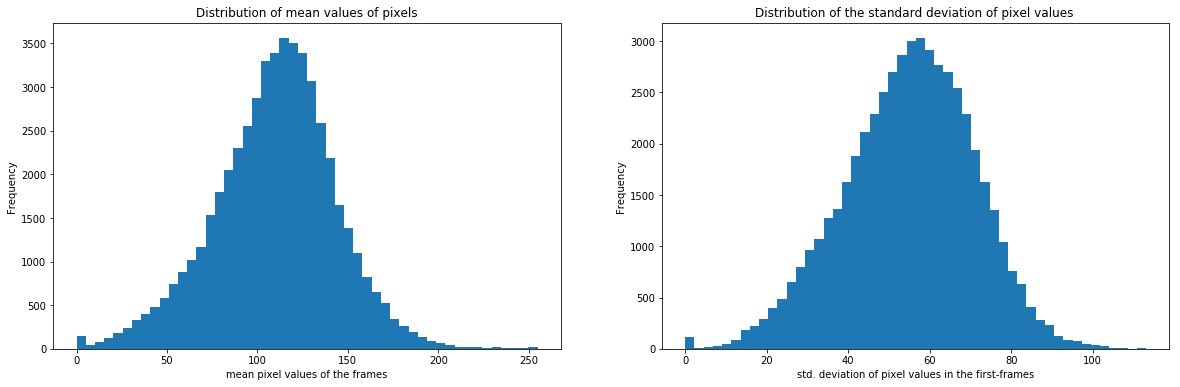

In [64]:
f, axs = plt.subplots(ncols=2, figsize=(20,6))
m = df['first_frame_mean']
m.plot.hist(bins=50, title="Distribution of mean values of pixels", ax=axs[0])
axs[0].set_xlabel("mean pixel values of the frames")

s = df['first_frame_std']
s.plot.hist(bins=50, title="Distribution of the standard deviation of pixel values ", ax=axs[1])
axs[1].set_xlabel("std. deviation of pixel values in the first-frames")
plt.show()

### 4) Number of frames per video
1) In the baseline something-something paper, they randomly pick 48 consecutive frames. For videos with less than 48 frames, they replicate the first and last frames to achieve the intended length.  
2) Most papers sample 10 to 30 consecutive frames at random and train on them.   

We are going to test **3 methods** to handle this:  

**method1 : Smthsmth baseline paper method**  
a) For videos < 48 frames  : replicate the first and last frames.  
b) For videos > 48 frames  : sample 48 consecutive frames such that the sampled videos segments are mostly in the center or the end of the whole video (using a binomial probability distribution with mean at len(video)/2.  
Both (a) and (b) pushes a prior on our model that the most important activities in the video occur mostly around the central few frames of the video.  

**method2 : Reject extremes**
a) Reject upper-extremes : Use only the videos with frame-length < 64 (around 16,650 videos)  
b) Reject videos with too few i.e. frame-length < 20


**method3 : dynamic fps**   
a) For videos < 48 frames  : randomly or deterministically duplicate frames in between the video to make it equal to 48  
b) For videos > 48 frames  : randomly or deterministically sample non-consecutive frames from the videos such that the total number of frames are always equal to 48

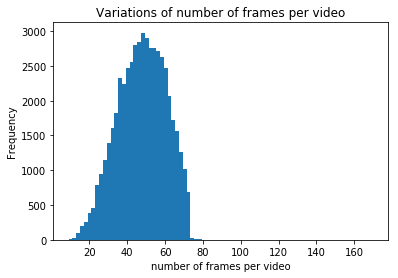

Frame length statistics= count    51934.000000
mean        48.094505
std         12.728623
min          9.000000
25%         39.000000
50%         49.000000
75%         58.000000
max        170.000000
Name: num_of_frames, dtype: float64
Mode of frame lengths = 49
Videos with too few frames = 1 (less than 10.0 frames)
Videos with too many frames = 10 (more than 86.0 frames)


In [111]:
z = df['num_of_frames']
ax = z.plot.hist(bins=80, title="Variations of number of frames per video")
ax.set_xlabel("number of frames per video")
plt.show()
print("Frame length statistics=",z.describe())
print("Mode of frame lengths =",int(z.mode()))
left_extreme = (z.mean()-3*z.std())
right_extreme = (z.mean()+3*z.std())
print("Videos with too few frames = {} (less than {} frames)".format(len(df[z<left_extreme]), round(left_extreme)))
print("Videos with too many frames = {} (more than {} frames)".format(len(df[z>right_extreme]), round(right_extreme)))

In [94]:
# # resize and crop image
# def process_im(im, desired_sz):
#     target_ds = float(desired_sz[0])/im.shape[0]
#     im = imresize(im, (desired_sz[0], int(np.round(target_ds * im.shape[1]))))
#     d = int((im.shape[1] - desired_sz[1]) / 2)
#     im = im[:, d:d+desired_sz[1]]
#     return im      

# test_im = imread(im_list[1])
# f, plts = plt.subplots(2,1, figsize=(8,10))
# plts[0].imshow(test_im)
# plts[0].set_title("original")
# test_im_proc = process_im(test_im, desired_im_sz)
# plts[1].imshow(test_im_proc)
# plts[1].set_title("processed")

# test_im_5 = imread(im_list[1].replace("001","005"))
# f, plts = plt.subplots(2,1, figsize=(8,10))
# plts[0].imshow(test_im_5)
# plts[0].set_title("original")
# test_im_proc = process_im(test_im_5, desired_im_sz)
# plts[1].imshow(test_im_proc)
# plts[1].set_title("processed")
# plt.show()

Repeating the analysis on the whole data after running the extract_20bn.py on all the videos.
Total videos = 211710


,Unnamed: 0,path,split,height,width,aspect_ratio,num_of_frames,first_frame_mean,first_frame_std,first_frame_min,first_frame_max,crop_group
0,0,/data/videos/something-something-v2/preprocess...,train,240.0,436.0,0.550459,49.0,0.351740,0.342476,0.0,1.000000,2
1,1,/data/videos/something-something-v2/preprocess...,train,240.0,427.0,0.562061,40.0,0.233361,0.255007,0.0,1.000000,2
2,2,/data/videos/something-something-v2/preprocess...,train,240.0,427.0,0.562061,46.0,0.177431,0.214418,0.0,0.917647,2
3,3,/data/videos/something-something-v2/preprocess...,train,240.0,427.0,0.562061,34.0,0.442003,0.263495,0.0,1.000000,2
4,4,/data/videos/something-something-v2/preprocess...,train,240.0,427.0,0.562061,47.0,0.159360,0.225231,0.0,1.000000,2


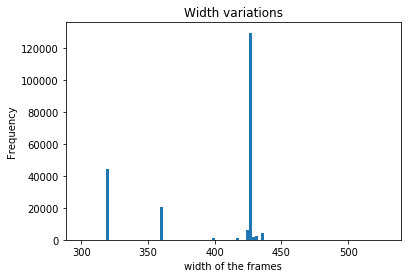

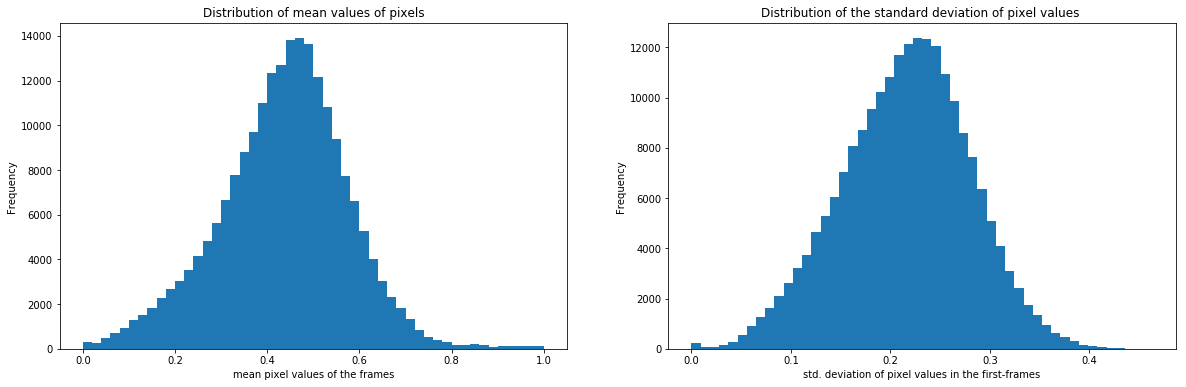

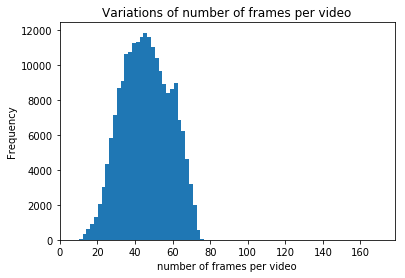

Frame length statistics= count    211710.000000
mean         45.917713
std          12.654471
min           8.000000
25%          36.000000
50%          46.000000
75%          56.000000
max         170.000000
Name: num_of_frames, dtype: float64
Mode of frame lengths = 44
Videos with too few frames = 0 (less than 8.0 frames)
Videos with too many frames = 16 (more than 84.0 frames)


In [8]:
df2 = pd.read_csv(data_dir+"/data.csv")
print("Repeating the analysis on the whole data after running the extract_20bn.py on all the videos.\nTotal videos = {}".format(len(df2)))
display(df2.head())
y = df2['width']
ax = y.plot.hist(bins=100, title="Width variations")
ax.set_xlabel("width of the frames")
plt.show()

f, axs = plt.subplots(ncols=2, figsize=(20,6))
m = df2['first_frame_mean']
m.plot.hist(bins=50, title="Distribution of mean values of pixels", ax=axs[0])
axs[0].set_xlabel("mean pixel values of the frames")

s = df2['first_frame_std']
s.plot.hist(bins=50, title="Distribution of the standard deviation of pixel values ", ax=axs[1])
axs[1].set_xlabel("std. deviation of pixel values in the first-frames")
plt.show()

z = df2['num_of_frames']
ax = z.plot.hist(bins=80, title="Variations of number of frames per video")
ax.set_xlabel("number of frames per video")
plt.show()

print("Frame length statistics=",z.describe())
print("Mode of frame lengths =",int(z.mode()))
left_extreme = (z.mean()-3*z.std())
right_extreme = (z.mean()+3*z.std())
print("Videos with too few frames = {} (less than {} frames)".format(len(df2[z<left_extreme]), round(left_extreme)))
print("Videos with too many frames = {} (more than {} frames)".format(len(df2[z>right_extreme]), round(right_extreme)))

In [11]:
print("Videos with number of frames > {} = {}".format(len(df2[z>64]), 64))
print("Videos with number of frames < {} = {}".format(len(df2[z<24]), 24))

Videos with number of frames > 89418 = 48
Videos with number of frames < 6645 = 24


In [16]:
df2 = pd.read_csv(data_dir+"/data.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
(df2[df2.split=="holdout"].width>400).value_counts()

True     13621
False     6379
Name: width, dtype: int64